# Regional Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings

import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from tools import (
    check_equal_period,
    create_cordex_grid,
    fix_360_longitudes,
    load_obs,
    mask_invalid,
    open_datasets,
    regional_means,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
)

dask.config.set(scheduler="single-threaded")

In [3]:
def traverseDir(root):
    for dirpath, dirnames, filenames in os.walk(root):
        for file in filenames:
            if file.endswith(".nc"):
                yield os.path.join(dirpath, file)

In [4]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.79 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37131,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.79 GiB
Comm: tcp://127.0.0.1:40549,Total threads: 1
Dashboard: http://127.0.0.1:35607/status,Memory: 7.86 GiB
Nanny: tcp://127.0.0.1:41107,


In [5]:
# Parameter papermill
index = "pr"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period = slice("1989", "2008")
reference_regions = "PRUDENCE"

In [6]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [7]:
variable = var_dic[index]["variable"]

In [8]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [9]:
# prudence
regions = regionmask.defined_regions.prudence

In [10]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [11]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
ref_seasmean = seasonal_mean(ref_on_rotated[eobs_var].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 15.11 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


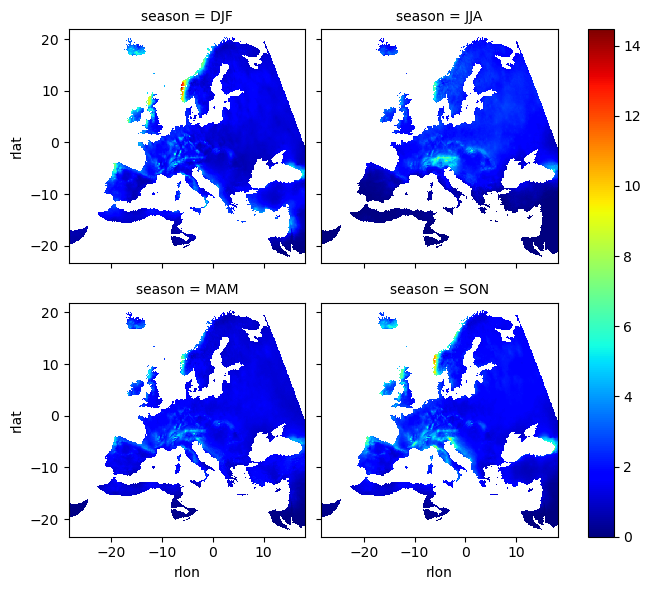

In [12]:
ref_seasmean.plot(col="season", col_wrap=2, cmap="jet")

## CERRA and ERA5

In [13]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    ds = load_obs(variable, dset)
    ds = ds.sel(time=period).compute()
    ds = fix_360_longitudes(ds, lonname="longitude")
    if not variable_mapping[dset][variable] == variable:
        ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
    ds = standardize_unit(ds, variable)
    dsets[dset] = ds

Convert precipitation from meters to millimeters (mm).


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 18.72 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [14]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [15]:
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=False)
    dsets[dset] = regridder(ds)

In [16]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [17]:
obs_seasonal_bias[variable] = obs_seasonal_bias[variable].where(
    (obs_seasonal_bias[variable] <= 1000) & (obs_seasonal_bias[variable] >= -1000)
)

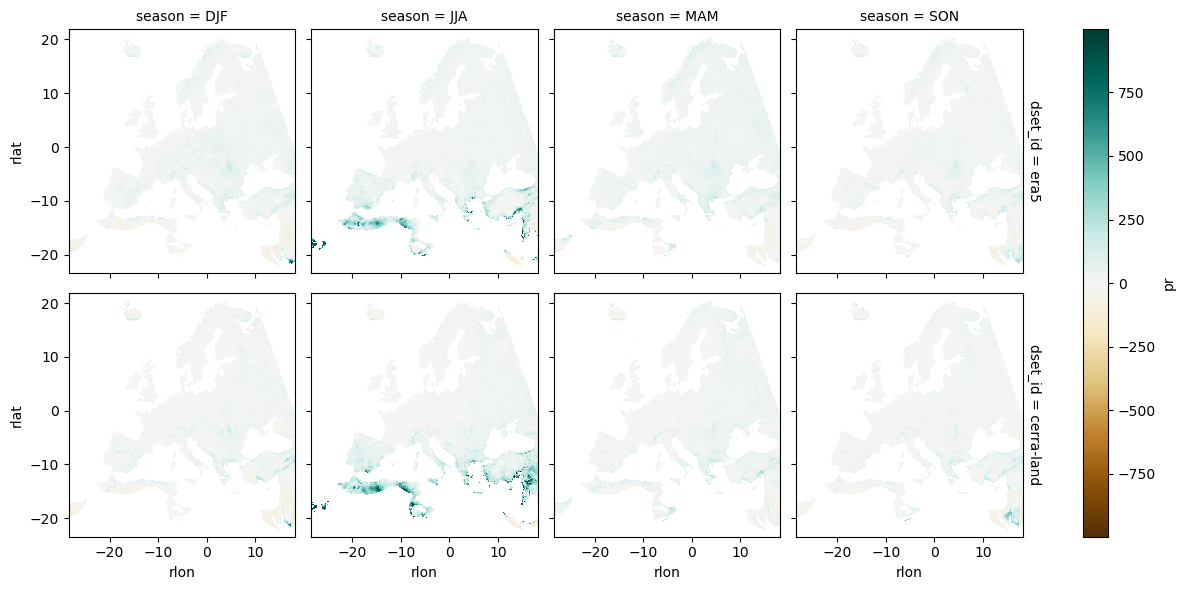

In [18]:
obs_seasonal_bias.pr.plot(row="dset_id", col="season", cmap="BrBG")

In [19]:
obs_regions = regional_means(obs_seasonal_bias, regions, aggr=var_dic[index]["aggr"])

## CMIP6

In [20]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [21]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'RegCM5-0'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp370.r2i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MIROC6.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920
Warning for CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.CNRM-ESM2-1.ssp126.r1i1p1f2.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-METNo.NorESM2-MM.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v2024120

/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415 will be ignored...


/home/lbuntemeyer/python/evaltools/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)
/home/lbuntemeyer/python/evaltools/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(


Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: "Receive multiple variables for key 'grid_mapping': ['rotated_pole', 'crs']. Expected only one. Please pass a list ['grid_mapping'] instead to get all v

In [22]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.mon.v20240920 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.KNMI.ERA5.evaluation.r1i1p1f1.RACMO23E.v1-r1.mon.v20241216 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.CLMcom-CMCC.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB.v1-r1.mon.v20250201 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX-CMIP6.EUR-12.GERICS.ERA5

In [23]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).


In [24]:
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       b

In [25]:
if var_dic[index]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean + 273.15)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[index]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }

seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.84 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.82 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site

In [26]:
seasonal_bias["pr"] = seasonal_bias["pr"].where(
    (seasonal_bias["pr"] <= 1000) & (seasonal_bias["pr"] >= -1000)
)

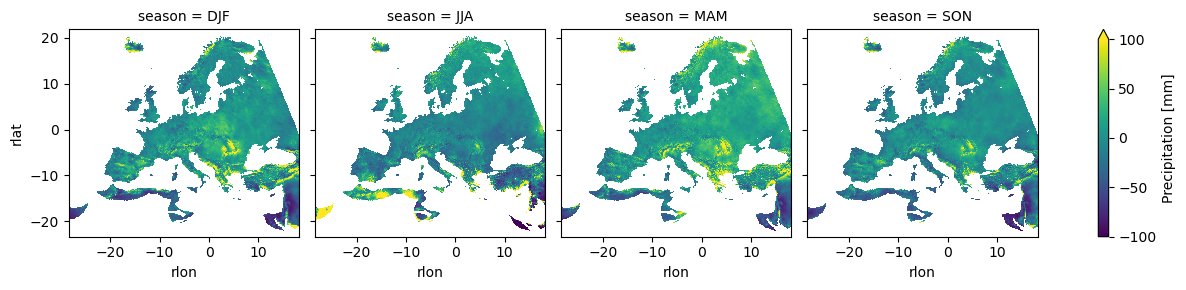

In [27]:
seasonal_bias["pr"].isel(dset_id=0).plot(col="season", vmin=-100, vmax=100)

In [28]:
dset_id_regions = regional_means(seasonal_bias, regions, aggr=var_dic[index]["aggr"])
dset_id_regions.to_netcdf(
    f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
)

## CMIP5 

In [29]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"

In [30]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Found: ['ALADIN53', 'ALADIN63', 'ALARO-0', 'CCLM4-8-17', 'COSMO-crCLIM-v1-1', 'HadREM3-GA7-05', 'RACMO22E', 'RCA4', 'REMO2009', 'REMO2015', 'RegCM4-2'] for variables: ['pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r0i0p0.COSMO-crCLIM-v1-1.v1.fx.v20191210
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.fx.v20140218
Found 22 datasets
decoding dataset CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210
Found 22 datasets
decoding dataset CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527
Found 22 datasets
decoding dataset CORDEX

In [31]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

Temporal coverage of CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140218 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 does not match with slice('1989', '2008', None)
Temporal coverage of CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 does not match with slice('1989', '2008', None)
Tem

In [32]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert precipitation from kg/m/s² to mm/s.
Convert precipitation from meters to millimeters (mm).
Convert pr

In [33]:
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (551, 551) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_485x485_4

In [34]:
if var_dic[index]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean + 273.15)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[index]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }

seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id"], delimiter="-"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/jsc-cordex/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 9.78 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [35]:
seasonal_bias[variable] = seasonal_bias[variable].where(
    (seasonal_bias[variable] <= 1000) & (seasonal_bias[variable] >= -1000)
)

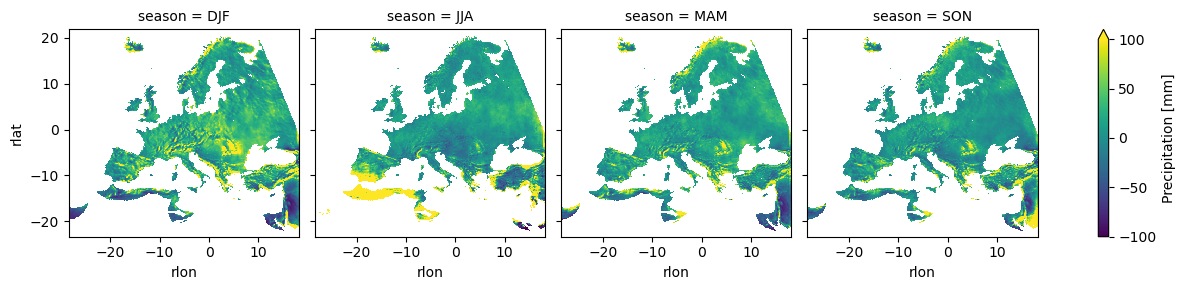

In [36]:
seasonal_bias["pr"].isel(dset_id=0).plot(col="season", vmin=-100, vmax=100)

In [37]:
dset_id_regions = regional_means(seasonal_bias, regions, aggr=var_dic[index]["aggr"])
dset_id_regions.to_netcdf(
    f"{save_results_path}/{index}_{mip_era}_{reference_regions}_{period.start}-{period.stop}.nc"
)

#### Load results for both CMIP5 and CMIP6 simulations

In [38]:
seasons = ["DJF", "MAM", "JJA", "SON"]

In [39]:
dset_id_regions_CMIP6 = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP6_{reference_regions}_{period.start}-{period.stop}.nc"
)
dset_id_regions_CMIP5 = xr.open_dataset(
    f"{save_results_path}/{index}_CMIP5_{reference_regions}_{period.start}-{period.stop}.nc"
)

In [40]:
df_CMIP6 = dset_id_regions_CMIP6.to_dataframe().reset_index()
df_CMIP5 = dset_id_regions_CMIP5.to_dataframe().reset_index()

In [41]:
df_obs = obs_regions.to_dataframe().reset_index()

In [42]:
print(np.min(df_CMIP5[variable]), np.max(df_CMIP5[variable]))
print(np.min(df_CMIP6[variable]), np.max(df_CMIP6[variable]))

-41.494738672604775 203.62741121152814
-23.313006342441394 101.61783376014029


/tmp/ipykernel_3215431/1790441799.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
/tmp/ipykernel_3215431/1790441799.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
/tmp/ipykernel_3215431/1790441799.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

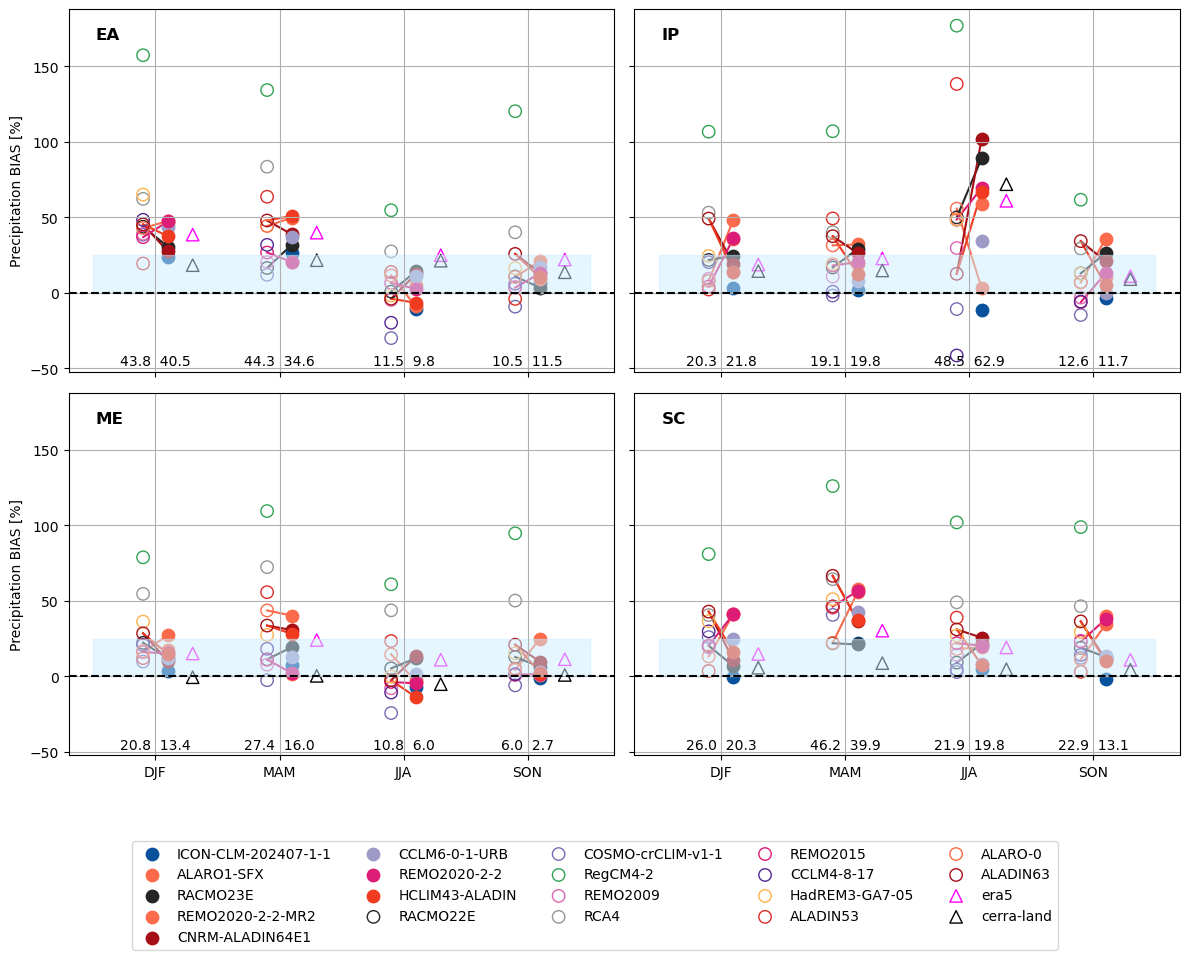

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["EA", "IP", "ME", "SC"]
default_color = "#fb6a4a"

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region = df_CMIP6[df_CMIP6["abbrevs"] == region]
    df_CMIP5_region = df_CMIP5[df_CMIP5["abbrevs"] == region]
    df_obs_region = df_obs[df_obs["abbrevs"] == region]

    df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region["season_num"] = df_obs_region["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP6_region["season_shifted"] = df_CMIP6_region["season_num"] + 0.1
    df_CMIP5_region["season_shifted"] = df_CMIP5_region["season_num"] - 0.1
    df_obs_region["season_shifted"] = df_obs_region["season_num"] + 0.3

    # Create lists to store the bias values for calculating median
    cmip6_biases = {season: [] for season in seasons}
    cmip5_biases = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip6_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region[df_CMIP5_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip5_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=80,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.5)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median = (
            np.nanmedian(cmip6_biases[season]) if cmip6_biases[season] else np.nan
        )
        cmip5_median = (
            np.nanmedian(cmip5_biases[season]) if cmip5_biases[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median:.1f}  {cmip6_median:.1f}",
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_A_bias_{index}_{period.start}-{period.stop}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

/tmp/ipykernel_3215431/3276859419.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
/tmp/ipykernel_3215431/3276859419.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
/tmp/ipykernel_3215431/3276859419.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

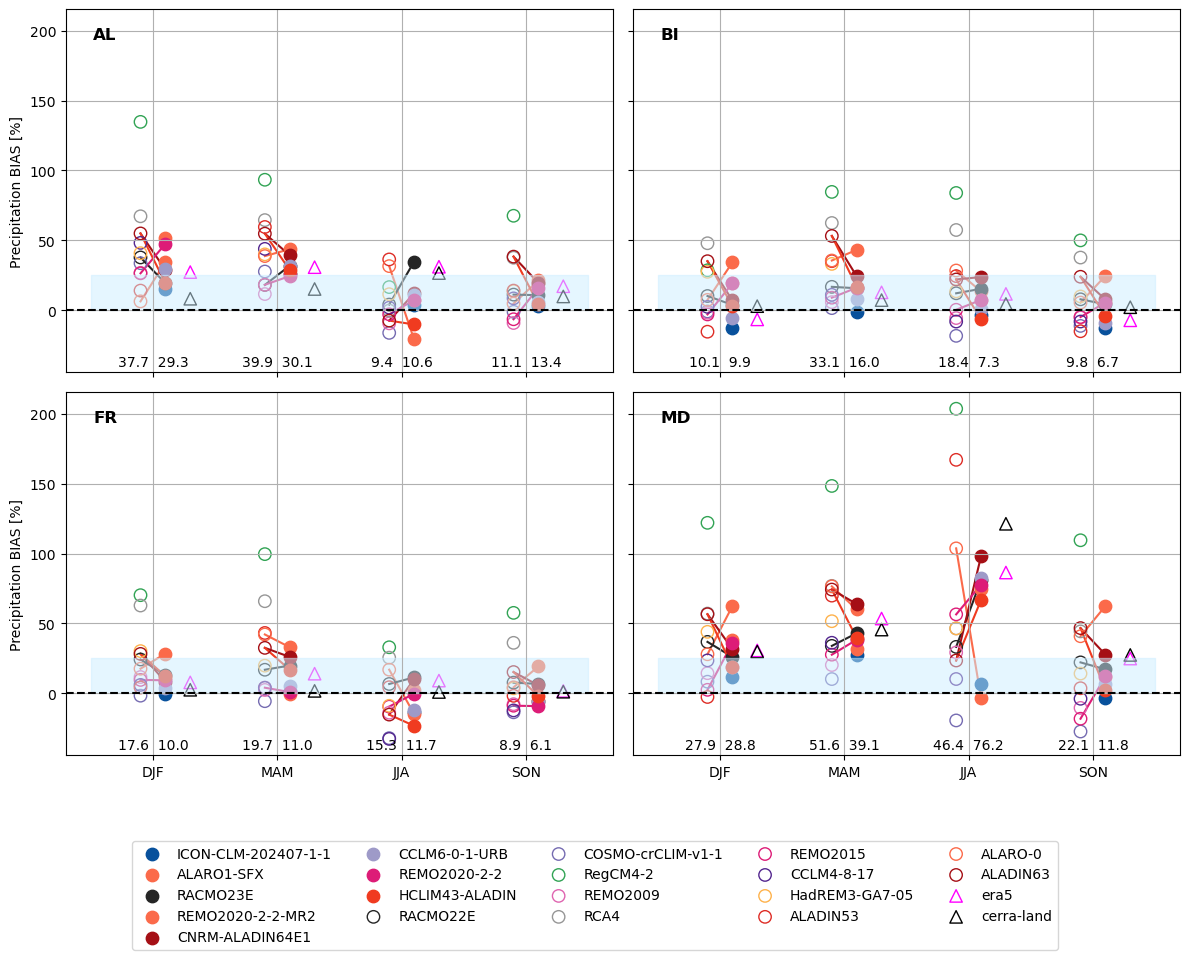

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

regs = ["AL", "BI", "FR", "MD"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.flatten()

handles = []
labels = []

for i, region in enumerate(regs):
    ax = axes[i]

    df_CMIP6_region = df_CMIP6[df_CMIP6["abbrevs"] == region]
    df_CMIP5_region = df_CMIP5[df_CMIP5["abbrevs"] == region]
    df_obs_region = df_obs[df_obs["abbrevs"] == region]

    df_CMIP6_region["season_num"] = df_CMIP6_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_CMIP5_region["season_num"] = df_CMIP5_region["season"].apply(
        lambda x: seasons.index(x)
    )
    df_obs_region["season_num"] = df_obs_region["season"].apply(
        lambda x: seasons.index(x)
    )

    df_CMIP6_region["season_shifted"] = df_CMIP6_region["season_num"] + 0.1
    df_CMIP5_region["season_shifted"] = df_CMIP5_region["season_num"] - 0.1
    df_obs_region["season_shifted"] = df_obs_region["season_num"] + 0.3

    # Create lists to store the bias values for calculating median
    cmip6_biases = {season: [] for season in seasons}
    cmip5_biases = {season: [] for season in seasons}

    for idx, row in df_CMIP6_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        parent = (
            eur_colors[eur_colors["model"] == dset_id].parent.values[0]
            if dset_id_in_table
            else None
        )

        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip6_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

        if parent is not None:
            row_cmip5 = df_CMIP5_region[df_CMIP5_region["dset_id"] == parent]
            if not row_cmip5.empty:
                row_cmip5 = row_cmip5[row_cmip5["season"] == row.season].iloc[0]
                ax.plot(
                    [row_cmip5["season_shifted"], row["season_shifted"]],
                    [row_cmip5[variable], row[variable]],
                    color=color,
                    linestyle="-",
                    zorder=0,
                )

    for idx, row in df_CMIP5_region.iterrows():
        dset_id = row["dset_id"]
        dset_id_in_table = dset_id in eur_colors.model.values
        color = (
            eur_colors[eur_colors["model"] == dset_id].color.values[0]
            if dset_id_in_table
            else default_color
        )
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="o",
            s=80,
        )

        # Collect bias values for median calculation
        cmip5_biases[row["season"]].append(abs(row[variable]))

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    for idx, row in df_obs_region.iterrows():
        dset_id = row["dset_id"]
        if "era5" in dset_id:
            color = "magenta"
        else:
            color = "black"
        scatter = ax.scatter(
            row["season_shifted"],
            row[variable],
            color=color,
            edgecolors=color,
            facecolor="none",
            marker="^",
            s=80,
        )

        if dset_id not in labels:
            handles.append(scatter)
            labels.append(dset_id)

    axes[0].set_ylabel(var_dic[index]["name"])
    axes[2].set_ylabel(var_dic[index]["name"])
    # Add region label in the top-left corner of each subplot
    ax.text(
        0.05,
        0.95,
        region,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        color="black",
        weight="bold",
    )

    ax.set_xticks([0, 1, 2, 3])  # Adjust tick positions according to the shift
    ax.set_xticklabels(seasons)  # Set the names of the seasons as labels

    ax.grid(True)
    ax.axhline(0, color="black", linestyle="--")

    if index == "pr":
        ax.fill_between([-0.5, 3.5], 0, 25, color="#cceeff", alpha=0.5)

    # Calculate and display the absolute median bias for each season for both CMIP5 and CMIP6
    for j, season in enumerate(seasons):
        cmip6_median = (
            np.nanmedian(cmip6_biases[season]) if cmip6_biases[season] else np.nan
        )
        cmip5_median = (
            np.nanmedian(cmip5_biases[season]) if cmip5_biases[season] else np.nan
        )

        # Add the absolute median bias text below the season labels
        ax.text(
            j,
            0.01,  # x in data coords, y as fraction of axes height (just above bottom)
            f"{cmip5_median:.1f}  {cmip6_median:.1f}",
            fontsize=10,
            verticalalignment="bottom",
            horizontalalignment="center",
            color="black",
            transform=ax.get_xaxis_transform(),  # y in axes coords, x in data coords
        )
#        ax.text(j, var_dic[index]['range'][0]+0.5, f'{cmip5_median:.1f}  {cmip6_median:.1f}',
#                fontsize=10, verticalalignment='top', horizontalalignment='center', color='black')

fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=5,
    fontsize=10,
)


plt.tight_layout()
plt.show()
fig.savefig(
    f"{save_figure_path}/{reference_regions}_B_bias_{index}_{period.start}-{period.stop}.png",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)